In [1]:
import psfws
import matplotlib.pyplot as plt
import numpy as np
import galsim
import pickle
import pandas as pd


In [2]:
seeds = list(range(6, 11)) + [22, 23, 25, 26, 27] + list(range(30, 40))
seeds += list(range(42, 171))

def get_maxSpd_profile(seeds):
    """gets the max ground speed and max free atm speed for a profile of simulations"""
    grdSpeedPsfws = np.zeros(len(seeds))
    f_atmspeedPsfws = np.zeros(len(seeds), dtype="object")
    for i in range(len(seeds)):
        ws = psfws.ParameterGenerator(seed=seeds[i])
        params= ws.draw_parameters(nl=6, location='com')
        grdSpeedPsfws[i] = params['speed'][0]
        f_atmspeedPsfws[i] = params['speed'][1:]
    rand_maxGround = np.max(grdSpeedPsfws)    
    rand_maxFree_atm = np.max([np.max(f_atmspeedPsfws[i]) for i in range(len(f_atmspeedPsfws))])   
    return rand_maxGround, rand_maxFree_atm


def gen_randSpd(seeds, rand_maxGround, rand_maxFree_atm):
    "generate random speeds with max profile speeds"
    grSpdsR = {}
    atmSpdsR = {}
    for seed in seeds:
        rng = galsim.BaseDeviate(seed)
        ud = galsim.UniformDeviate(rng)
        grSpdsR[seed] = ud() * rand_maxGround
        atmSpdsR[seed] = [ud() * rand_maxFree_atm for _ in range(5)]
    return grSpdsR, atmSpdsR


def plothist(ax,para,bs, lbl=""):
    """plot histogram of para as points with poisson uncertainty"""
    ax.hist(para, bins=bs, histtype='step', color="salmon")
    return ax

In [3]:
# LOADING DATA
f_atm = ["atm_summary_psfws_df.p", "atm_summary_rand_df.p", "atm_summary_randMatch_df.p"]
atm_psfws, atm_rand, atm_randMatch = [pickle.load(open("validate-psfws/summariesCircle/"+f_atm[i], "rb")) for i in range(3)]

for atm in [atm_psfws, atm_rand, atm_randMatch]:
    atm['dir_0'] = [atm['direction'].iloc[i][0].deg%180 for i in range(len(atm))]
    atm['spd_0'] = [atm['speed'].iloc[i][0] for i in range(len(atm))]
    atm['spd_atm'] = [atm['speed'].iloc[i][1:] for i in range(len(atm))]


In [4]:
# get forecast data
seed = 9283456
ws = psfws.ParameterGenerator(seed=seed)
data_fa = ws.__getattribute__("data_fa")



# add date time to psfws sim stats df
time = [data_fa.index[i] for i in range(len(data_fa))]
speeds = {}
for i in range(len(data_fa)):
    speeds[time[i]] = ws.get_parameters(time[i],nl=6, location="com")['speed']

dt = []
for i in range(len(atm_psfws)):
    for j in range(len(time)):
        if all(atm_psfws["speed"].iloc[i] == speeds[time[j]]):
            dt.append(time[j])
atm_psfws['datetime'] = dt


''

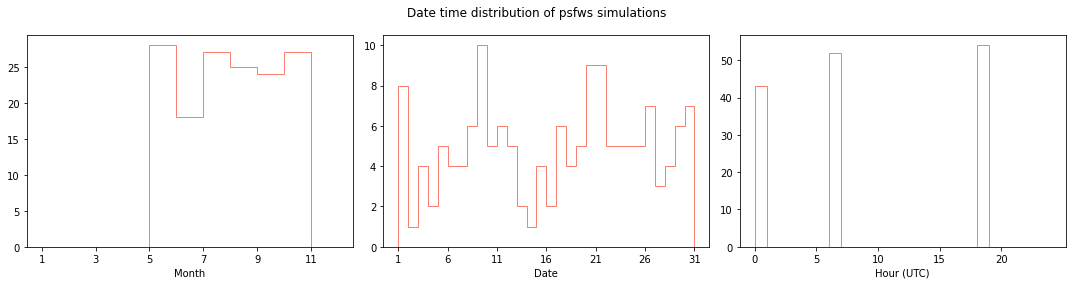

In [5]:
# plotting
fig,ax = plt.subplots(1,3,figsize=(15,4))
ax[0] = plothist(ax[0], [dt[i].month for i in range(len(dt))],np.arange(1,13))
ax[0].set_xticks(np.arange(1,13,2))
ax[0].set_xlabel("Month")

ax[1] = plothist(ax[1], [dt[i].day for i in range(len(dt))],np.arange(1,32))
ax[1].set_xticks(np.arange(1,32,5))
ax[1].set_xlabel("Date")

ax[2] = plothist(ax[2], [dt[i].hour for i in range(len(dt))],np.arange(0,25))
ax[2].set_xticks(np.arange(0,25,5))
ax[2].set_xlabel("Hour (UTC)")

fig.suptitle("Date time distribution of psfws simulations")
fig.tight_layout()
;

In [6]:
print("Velocity in in simulation on sherlock ")
atm_psfws[["speed","datetime"]].iloc[39]['speed']

Velocity in in simulation on sherlock 


array([ 6.65      , 25.85109833, 52.27451174, 44.96287784, 18.76973346,
       13.92689783])

In [7]:
print("Velocity with draw method, seed=61")
ws = psfws.ParameterGenerator(61)
ws.draw_parameters(nl=6,location="com")['speed']


Velocity with draw method, seed=61


array([ 5.        ,  9.86395416, 22.726852  , 33.79542207, 15.69124837,
       11.42964904])

In [2]:
print("Velocity with get method, seed=61")
ws = psfws.ParameterGenerator(61)
ws.get_parameters('2019-06-01 06:00:00+00:00',nl=6)['speed']

Velocity with get method, seed=61


array([ 6.65      , 26.16756335, 60.19290877, 45.18959335, 19.04753162,
       14.21183323])

In [4]:
ws.draw_datapoint()

Timestamp('2019-06-01 06:00:00+0000', tz='UTC')

In [5]:
ws.